In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[]

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
from tensorflow.keras import Model
from tensorflow.keras import metrics
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [6]:
from lib.pyimagesearch import LearningRateFinder
from lib.clr_callback import CyclicLR

In [7]:
import stanza

In [8]:
from sentence_transformers import SentenceTransformer

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

In [10]:
dfTrain = pd.read_csv('../Data/train.csv', encoding = 'utf-8', lineterminator="\n")

In [11]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [12]:
nlp = stanza.Pipeline('en', logging_level='WARN', processors='tokenize,pos,constituency, sentiment')

In [13]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(model.encode)

In [14]:
excerpts = transformer.transform(dfTrain['excerpt'])

In [15]:
dev_X = excerpts

dev_y = dfTrain['target']

In [41]:
inputs = Input(shape=(384,))
x = Rescaling(scale=1./255)(inputs)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation="linear")(x)
dense_model = Model(inputs, outputs)

dense_model.compile(optimizer=SGD(learning_rate=0.01), loss="mean_absolute_error", metrics=["mean_absolute_error"])

In [42]:
dense_history = dense_model.fit(dev_X, dev_y, epochs=10, batch_size=32, validation_split=0.25, verbose=0)

<AxesSubplot:>

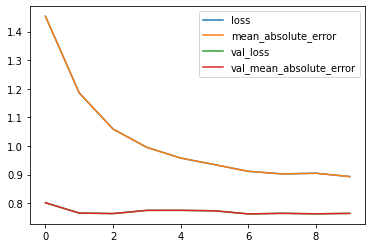

In [43]:
pd.DataFrame(dense_history.history).plot()

In [45]:
inputs = Input(shape=(384,))
x = Embedding(input_dim=2834, input_length=384, output_dim=384)(inputs)
x = SimpleRNN(384, activation="tanh", return_sequences=True)(x)
x = SimpleRNN(384, activation="tanh", return_sequences=True)(x)
outputs = Dense(1, activation="linear")(x)
rnn = Model(inputs, outputs)

rnn.compile(optimizer=SGD(learning_rate=0.03), loss="mean_absolute_error", metrics=["mean_absolute_error"])

In [29]:
rnn.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 384)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 384, 384)          1088256   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 384, 384)          295296    
                                                                 
 dense_3 (Dense)             (None, 384, 1)            385       
                                                                 
Total params: 1,383,937
Trainable params: 1,383,937
Non-trainable params: 0
_________________________________________________________________


In [30]:
rnn_history = rnn.fit(dev_X, dev_y, epochs=20, batch_size=32, validation_split=0.25, 
                      callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<AxesSubplot:>

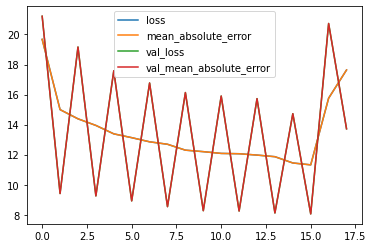

In [31]:
pd.DataFrame(rnn_history.history).plot()

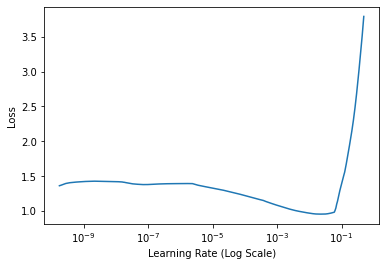

In [46]:
lr_finder = LearningRateFinder(rnn)

lr_finder.find(trainData=(dev_X, dev_y), 
               startLR=1e-10, endLR=1e+1, 
               epochs=5, batchSize=32, verbose=0)

lr_finder.plot_loss(skipBegin=10, skipEnd=1, title="")

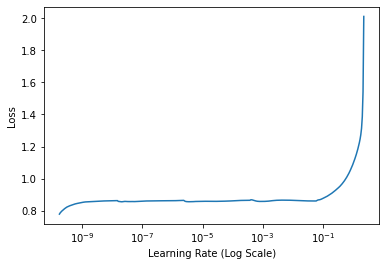

In [44]:
lr_finder = LearningRateFinder(dense_model)

lr_finder.find(trainData=(dev_X, dev_y), 
               startLR=1e-10, endLR=1e+1, 
               epochs=5, batchSize=32, verbose=0)

lr_finder.plot_loss(skipBegin=10, skipEnd=1, title="")